**Mounting colab on drive**

In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Hate Video task'
assert FOLDERNAME is not None, "[!] Enter the foldername."

Mounted at /content/drive


In [ ]:
import cv2
import math
from tqdm import tqdm
from glob import glob
import numpy as np
import pandas as pd
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader
from statistics import mode
%matplotlib inline
dtype = torch.cuda.FloatTensor
device = torch.device("cuda:0")

**Training data set**

In [ ]:
data_folder = '/content/drive/My Drive/Hate Video task/Dataset/'
name_with_labels = pd.read_csv(data_folder+'train_data1.csv', delimiter = ',',header = 0)
print(name_with_labels.shape)
print(name_with_labels.head)

(2422, 2)
<bound method NDFrame.head of                                                  Images  Classes
0     /content/drive/My Drive/Hate Video task/Datase...        1
1     /content/drive/My Drive/Hate Video task/Datase...        1
2     /content/drive/My Drive/Hate Video task/Datase...        1
3     /content/drive/My Drive/Hate Video task/Datase...        1
4     /content/drive/My Drive/Hate Video task/Datase...        1
...                                                 ...      ...
2417  /content/drive/My Drive/Hate Video task/Datase...        0
2418  /content/drive/My Drive/Hate Video task/Datase...        0
2419  /content/drive/My Drive/Hate Video task/Datase...        0
2420  /content/drive/My Drive/Hate Video task/Datase...        0
2421  /content/drive/My Drive/Hate Video task/Datase...        0

[2422 rows x 2 columns]>


In [ ]:
train_images = []
for i in tqdm(range(name_with_labels.shape[0])):
  img = cv2.imread(name_with_labels.iloc[i]['Images'])
  img = cv2.resize(img, (224, 224))
  img = img.astype('float32')
  img /= 255.
  train_images.append(img)
X = np.array(train_images)
print(X.shape)

100%|██████████| 2422/2422 [32:38<00:00,  1.24it/s]


(2422, 224, 224, 3)


In [ ]:
y = name_with_labels['Classes']
print(y.shape)

(2422,)


In [ ]:
X = np.transpose(X, [0, 3, 1, 2])
print(X.shape)

(2422, 3, 224, 224)


**Loading base model and defining model on top of that for classification**

In [ ]:
tensor_x = torch.Tensor(X)
tensor_y = torch.Tensor(y.values)
del X
del y
Base_model = models.vgg16(pretrained = True)
Base_model.classifier = Base_model.classifier[:-7]

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


In [ ]:
tensor_x.to(device)
tensor_x = tensor_x.type(torch.cuda.FloatTensor)
Base_model.to(device)

Base_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
v_model = nn.Sequential(
    nn.Linear(7*7*512, 1024),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(128, 2),
    nn.Softmax(dim = 1)
).to(device)
print(v_model.parameters)

<bound method Module.parameters of Sequential(
  (0): Linear(in_features=25088, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=256, out_features=128, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=128, out_features=2, bias=True)
  (13): Softmax(dim=1)
)>


In [ ]:
# def initialize_weights(m):
#   if isinstance(m, nn.Linear) or isinstance(m, nn.ConvTranspose2d):
#     nn.init.xavier_uniform_(m.weight.data)

# initialize_weights(v_model)

In [ ]:
PATH = '/content/drive/My Drive/Hate Video task/Models/Model1.pt'
v_model.load_state_dict(torch.load(PATH))
v_model.to(device)

Sequential(
  (0): Linear(in_features=25088, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=1024, out_features=512, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.5, inplace=False)
  (9): Linear(in_features=256, out_features=128, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=128, out_features=2, bias=True)
  (13): Softmax(dim=1)
)

In [ ]:
def train(model, data_loader, epochs, batch_size = 32, lr = 0.0001):
  optimizer = optim.Adam(model.parameters(), lr = lr, betas = (0.5, 0.999), weight_decay=1e-5)
  loss = nn.CrossEntropyLoss()
  net_losses = []
  k = np.arange(epochs)
  for i in k:
    sum = 0.0
    count = 0
    for x,y in data_loader:
      count+=1
      optimizer.zero_grad()
      x = Base_model(x)
      dim = x.shape
      x = torch.reshape(x, (dim[0], 7*7*512))
      scores = model(x)
      print(scores.shape)
      print(y.shape)
      loss_curr = loss(scores, y)

      sum += loss_curr
      loss_curr.backward()
      optimizer.step()
    net_losses.append(sum/count)
    print("Current loss is :- {}".format(sum/count))
    if i%25==24:
      lr/=2
    torch.cuda.empty_cache()
  return net_losses

tensor_y.to(device)
tensor_y = tensor_y.type(torch.cuda.torch.cuda.LongTensor)

In [ ]:
train_fin_dataset = TensorDataset(tensor_x, tensor_y)
train_dataloader = DataLoader(train_fin_dataset, batch_size = 16)

In [ ]:
net_loss = train(v_model, train_dataloader, 100, 16, 0.000001) 

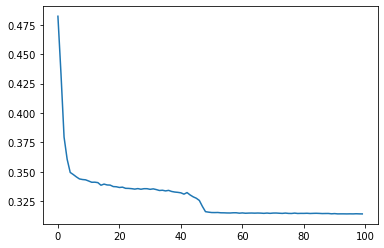

In [ ]:
range = np.arange(100)
plt.plot(range, net_loss)

**Saving the wieghts of model**

In [ ]:
path = '/content/drive/My Drive/Hate Video task/Models/'
torch.save(v_model.state_dict(), path+'Model1.pt')